# **トラス要素を用いたマトリックス構造解析（Pythonコード）**
第04回_マトリックス構造解析で紹介した，３節点２要素のトラス構造に鉛直下向きの荷重を作用させた場合の変形を求めるプログラム（スライド p.21を参照のこと）

↓ 解析結果を可視化した際に日本語が文字化けしないようするために，日本語表示を可能とするライブラリーをインストールします．

In [2]:
!pip install japanize-matplotlib

### **３節点２要素のトラス構造に荷重を作用させた場合の変形に関する構造解析（第4回講義資料 p.21参照）**

★★★ 第04回 P.21 課題（鉛直荷重）モデルを解析します ★★★

--- 1. 入力データ ---
節点: {1: (0.0, 0.0), 2: (1.5, -0.8660254037844386), 3: (2.0, 0.0)}
要素: {1: (1, 2), 2: (2, 3)}
E=1.0, A=1.0
荷重: {1: (0.0, 0.0), 2: (0.0, -1.0), 3: (0.0, 0.0)}
境界条件: {1: (True, True), 2: (False, False), 3: (True, True)}

--- 2. 要素剛性行列の計算とアセンブリ ---
要素 1 (節点 1-2): L=1.73, c=0.87, s=-0.50
要素 2 (節点 2-3): L=1.00, c=0.50, s=0.87

アセンブリ後の全体剛性行列 K_all (6x6):
 [[ 0.433 -0.25  -0.433  0.25   0.     0.   ]
 [-0.25   0.144  0.25  -0.144  0.     0.   ]
 [-0.433  0.25   0.683  0.183 -0.25  -0.433]
 [ 0.25  -0.144  0.183  0.894 -0.433 -0.75 ]
 [ 0.     0.    -0.25  -0.433  0.25   0.433]
 [ 0.     0.    -0.433 -0.75   0.433  0.75 ]]

--- 3. 境界条件の適用 ---
自由な自由度 (DOFs): [2, 3]
解くべき部分剛性方程式 K_ff (講義P.21相当):
 [[0.683 0.183]
 [0.183 0.894]]
対応する荷重ベクトル F_f: [ 0. -1.]

--- 4. 解析結果 (変位) ---
節点 1: U_1 =  0.0000000, V_1 =  0.0000000
節点 2: U_2 =  0.3169873, V_2 = -1.1830127
節点 3: U_3 =  0.0000000, V_3 =  0.0000000

--- 5. 可視化 (変位を 0.1 倍で表示) ---


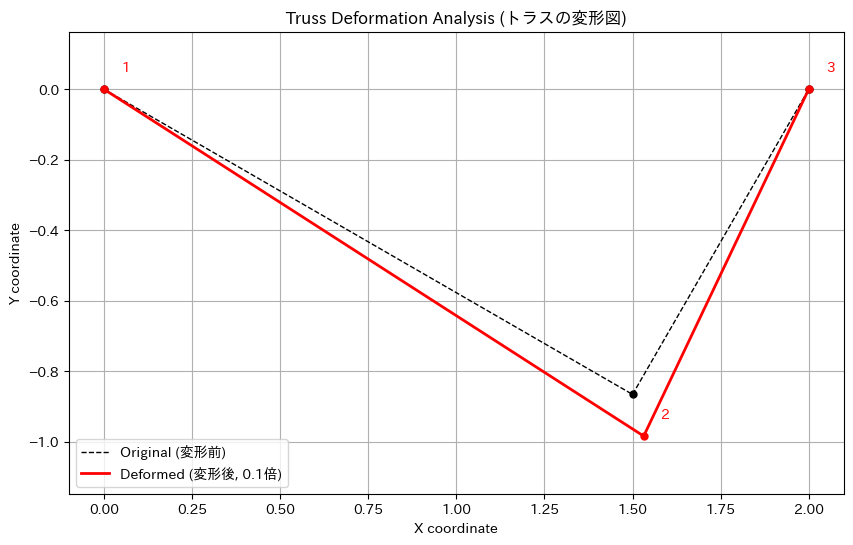

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib  # これだけで多くの環境で日本語OK

def plot_truss(nodes, elements, U_all, scale_factor=1.0):
    """
    トラスの変形前と変形後を描画する関数 (可視化担当)

    Args:
        nodes (dict): 節点座標 {節点番号: (x, y)}
        elements (dict): 要素 {要素番号: (i端, j端)}
        U_all (np.array): 全変位ベクトル (解析結果)
        scale_factor (float): 変位の表示倍率
    """

    # 変形後の節点座標を計算
    nodes_deformed = {}
    for node_id, (x, y) in nodes.items():
        dof_x = (node_id - 1) * 2
        dof_y = (node_id - 1) * 2 + 1

        # 変位に変倍率を適用
        u = U_all[dof_x] * scale_factor
        v = U_all[dof_y] * scale_factor

        nodes_deformed[node_id] = (x + u, y + v)

    plt.figure(figsize=(10, 6))

    # 1. 変形前の構造を描画 (破線・黒)
    for el_id, (i, j) in elements.items():
        x = [nodes[i][0], nodes[j][0]]
        y = [nodes[i][1], nodes[j][1]]
        plt.plot(x, y, 'k--', linewidth=1.0, label='Original (変形前)' if el_id == 1 else "")

    # 2. 変形後の構造を描画 (実線・赤)
    for el_id, (i, j) in elements.items():
        x_def = [nodes_deformed[i][0], nodes_deformed[j][0]]
        y_def = [nodes_deformed[i][1], nodes_deformed[j][1]]
        plt.plot(x_def, y_def, 'r-', linewidth=2.0, label=f'Deformed (変形後, {scale_factor}倍)' if el_id == 1 else "")

    # 3. 節点を描画
    for node_id, (x, y) in nodes.items():
        plt.plot(x, y, 'ko', markersize=5) # 変形前の節点

    for node_id, (x_def, y_def) in nodes_deformed.items():
        plt.plot(x_def, y_def, 'ro', markersize=5) # 変形後の節点
        plt.text(x_def + 0.05, y_def + 0.05, f'{node_id}', color='red') # 節点番号


    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Truss Deformation Analysis (トラスの変形図)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal') # X軸とY軸のスケールを合わせる
    plt.show()


def solve_truss(nodes, elements, E, A, bcs, loads):
    """
    トラス構造解析を実行する関数 (計算担当)

    Args:
        nodes (dict): 節点座標
        elements (dict): 要素定義
        E (float): ヤング係数
        A (float): 断面積
        bcs (dict): 境界条件
        loads (dict): 荷重ベクトル

    Returns:
        np.array: 全変位ベクトル (U_all)
    """

    # -----------------------------------------------------
    # 1. 入力データの確認 (メインから渡されたもの)
    # -----------------------------------------------------
    print("--- 1. 入力データ ---")
    print(f"節点: {nodes}")
    print(f"要素: {elements}")
    print(f"E={E}, A={A}")
    print(f"荷重: {loads}")
    print(f"境界条件: {bcs}\n")

    # -----------------------------------------------------
    # 2. 全体剛性行列 [K_all] の構築 (アセンブリ)
    # -----------------------------------------------------

    num_nodes = len(nodes)
    num_dofs = num_nodes * 2
    K_all = np.zeros((num_dofs, num_dofs))
    F_all = np.zeros(num_dofs)

    print("--- 2. 要素剛性行列の計算とアセンブリ ---")

    for el_id, (i, j) in elements.items():

        xi, yi = nodes[i]
        xj, yj = nodes[j]
        dx = xj - xi
        dy = yj - yi
        L = np.sqrt(dx**2 + dy**2)
        c = dx / L
        s = dy / L

        # 部材座標系の要素剛性行列 [k] (4x4)
        k_local = (E * A / L) * np.array([
            [ 1,  0, -1,  0],
            [ 0,  0,  0,  0],
            [-1,  0,  1,  0],
            [ 0,  0,  0,  0]
        ])

        # 座標変換マトリクス [R] (4x4)
        R_theta = np.array([
            [ c,  s],
            [-s,  c]
        ])
        R = np.zeros((4, 4))
        R[0:2, 0:2] = R_theta
        R[2:4, 2:4] = R_theta

        # [K'] = [R]^T [k] [R]
        K_global = R.T @ k_local @ R

        print(f"要素 {el_id} (節点 {i}-{j}): L={L:.2f}, c={c:.2f}, s={s:.2f}")

        # [K'] を [K_all] にアセンブリ
        dofs = [ (i-1)*2, (i-1)*2 + 1, (j-1)*2, (j-1)*2 + 1 ]
        for r in range(4):
            for col in range(4):
                K_all[dofs[r], dofs[col]] += K_global[r, col]

    for node_id, (Fx, Fy) in loads.items():
        F_all[(node_id-1)*2]     = Fx
        F_all[(node_id-1)*2 + 1] = Fy

    print(f"\nアセンブリ後の全体剛性行列 K_all ({num_dofs}x{num_dofs}):\n {np.round(K_all, 3)}")

    # -----------------------------------------------------
    # 3. 境界条件の適用と求解
    # -----------------------------------------------------

    free_dofs = []
    fixed_dofs = []
    for node_id, (x_fixed, y_fixed) in bcs.items():
        dof_x = (node_id - 1) * 2
        dof_y = (node_id - 1) * 2 + 1
        if x_fixed: fixed_dofs.append(dof_x)
        else: free_dofs.append(dof_x)
        if y_fixed: fixed_dofs.append(dof_y)
        else: free_dofs.append(dof_y)

    free_dofs.sort()
    K_ff = K_all[np.ix_(free_dofs, free_dofs)]
    F_f = F_all[free_dofs]

    print(f"\n--- 3. 境界条件の適用 ---")
    print(f"自由な自由度 (DOFs): {free_dofs}")
    print(f"解くべき部分剛性方程式 K_ff (講義P.21相当):\n {np.round(K_ff, 3)}")
    print(f"対応する荷重ベクトル F_f: {F_f}")

    # 連立方程式を解く
    try:
        U_f = np.linalg.solve(K_ff, F_f)
    except np.linalg.LinAlgError:
        print("エラー: 剛性行列が特異であり、解析できませんでした。")
        print("（拘束条件が不足していないか確認してください）")
        return None

    # -----------------------------------------------------
    # 4. 結果の整理
    # -----------------------------------------------------

    U_all = np.zeros(num_dofs)
    U_all[free_dofs] = U_f

    print(f"\n--- 4. 解析結果 (変位) ---")
    for i in range(num_nodes):
        u = U_all[i*2]
        v = U_all[i*2 + 1]
        print(f"節点 {i+1}: U_{i+1} = {u: .7f}, V_{i+1} = {v: .7f}")

    return U_all


# =====================================================
# メイン実行ブロック
# 【第04回 P.21 課題（鉛直荷重）モデル】
# =====================================================

if __name__ == "__main__":

    # -----------------------------------------------------
    # 1. 解析条件の定義 (第04回 P.21 課題モデル)
    # -----------------------------------------------------

    # 節点座標 {節点番号: (x, y)}
    # (講義 P.27 と同じ)
    nodes = {
        1: (0.0,  0.0),  # 節点1
        2: (1.5, -0.8660254037844386),  # 節点2 (L=1 と仮定)
        3: (2.0,  0.0)   # 節点3 (L=1 と仮定)
    }

    # 要素の定義 {要素番号: (i端節点, j端節点)}
    # (講義 P.21 と同じ)
    elements = {
        1: (1, 2),  # 要素1 (節点1 -> 2)
        2: (2, 3)   # 要素2 (節点2 -> 3)
    }

    # 材料・断面特性
    E = 1.0  # ヤング係数 (仮定)
    A = 1.0  # 断面積 (仮定)

    # 境界条件 {節点番号: (x方向拘束, y方向拘束)}
    # (講義 P.27 と同じ)
    bcs = {
        1: (True, True),  # 節点1 (ピン固定)
        2: (False, False),# 節点2 (自由)
        3: (True, True)   # 節点3 (ピン固定)
    }

    # 荷重ベクトル {節点番号: (Fx, Fy)}
    # ★ P.21の課題に合わせて、節点2に「鉛直方向(Fy)」の荷重を設定
    loads = {
        1: (0.0,  0.0),
        2: (0.0, -1.0), # 節点2に水平荷重 P=1 を作用 (Fx=0.0, Fy= -1.0)
        3: (0.0,  0.0)
    }

    # 可視化のスケールファクタ
    # (変位を 0.1倍 して表示)
    scale_factor = 0.1

    # -----------------------------------------------------
    # 2. 解析の実行
    # -----------------------------------------------------
    print("★★★ 第04回 P.21 課題（鉛直荷重）モデルを解析します ★★★\n")
    # 関数を呼び出し、入力データを渡す
    U_result = solve_truss(nodes, elements, E, A, bcs, loads)

    # -----------------------------------------------------
    # 3. 可視化の実行
    # -----------------------------------------------------
    if U_result is not None:
        print(f"\n--- 5. 可視化 (変位を {scale_factor} 倍で表示) ---")
        plot_truss(nodes, elements, U_result, scale_factor=scale_factor)